# TME 3 - Régularisation L1

In [1]:
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

cancer = datasets.load_breast_cancer()
X = cancer.data
print("shape of X:", X.shape)
y = cancer.target
print("shape of Y:", y.shape)
print("classes in Y: ", np.unique(y))
X, y = shuffle(X, y)

# Restricting data
X = X[:100,:10]
y = y[:100]


shape of X: (569, 30)
shape of Y: (569,)
classes in Y:  [0 1]


In [24]:
from scipy.optimize import approx_fprime, check_grad, minimize

def decision(theta, X):
    return np.sign(X.dot(theta)) / 2 + 0.5

def loss(theta, X, y, pen):
    mse = ((y - decision(theta, X))**2).mean()
    return mse + pen * np.linalg.norm(theta, 1)

print("########### Gradient printing: ###########")
for i in range(10):
    print("=== Iteration %d ===" % i)
    theta_init = np.random.random(X[0].shape) - 0.5
    func = lambda t: loss(t, X, y, pen)
    grad = approx_fprime(theta_init, func, epsilon=1)
    print("Theta init:   ", theta_init)
    print("Gradient:     ",grad)

    
def gradient_l1(theta, X, y, max_iter=100, step=1e-1, pen=0.1, verbose=0, plot=False):
    """ Performs gradient clipping to find the best theta
    :param:
    
    :return:"""
    
    (l, n) = X.shape
    losses = []
    for it in range(max_iter):
        if verbose >= 1:
            print("###########  Step", it, ": #################")
        for i in range(l):
            idx = np.random.randint(0, l)
            if verbose >= 2:
                print("========= i = %d, idx = %d ===========" % (i, idx))
            local_loss = lambda t: loss(t, np.array([X[idx]]), np.array([y[idx]]), pen)
            grad = approx_fprime(theta, local_loss, epsilon=step)
            theta_prime = theta - step * grad
            
            if verbose >= 2:
                print("Random sample:", X[idx])
                print("Gradient:     ",grad)
                print("Theta before: ", theta)
            theta_prime[theta * theta_prime < 0] = 0
            theta = theta_prime
            if verbose >= 2:
                print("Theta after:  ", theta)
                
        general_loss = loss(theta, X, y, pen)
        losses.append(general_loss)
        if verbose >= 1:
            print("L = %f" % (general_loss))
    
    if plot:
        plt.plot(losses)
        plt.title("Evolution of loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
    return theta

########### Gradient printing: ###########
=== Iteration 0 ===
Theta init:    [-0.45  0.49 -0.22 ..., -0.46  0.08 -0.14]
Gradient:      [ 0.    0.01  0.01 ...,  0.    0.01  0.01]
=== Iteration 1 ===
Theta init:    [-0.32 -0.45  0.42 ..., -0.25 -0.42  0.49]
Gradient:      [ 0.    0.    0.01 ...,  0.01  0.    0.01]
=== Iteration 2 ===
Theta init:    [-0.34  0.14  0.18 ...,  0.02 -0.25 -0.15]
Gradient:      [ 0.    0.01  0.01 ...,  0.01  0.    0.01]
=== Iteration 3 ===
Theta init:    [-0.44 -0.37  0.2  ..., -0.39  0.01  0.3 ]
Gradient:      [ 0.    0.   -0.47 ...,  0.    0.01  0.01]
=== Iteration 4 ===
Theta init:    [ 0.42  0.26  0.24 ...,  0.26  0.31 -0.12]
Gradient:      [ 0.01  0.01  0.01 ...,  0.01  0.01  0.01]
=== Iteration 5 ===
Theta init:    [-0.47  0.45  0.33 ...,  0.35  0.38 -0.03]
Gradient:      [ 0.    0.01 -0.05 ...,  0.01  0.01  0.01]
=== Iteration 6 ===
Theta init:    [ 0.29 -0.17  0.36 ..., -0.33 -0.17  0.27]
Gradient:      [ 0.01  0.01  0.01 ...,  0.    0.01  0.01]
=== I

theta found with gradient descent: [-0.   -0.   -0.01 ..., -0.01 -0.   -0.  ]
Decision function: [ 0.  0.  0. ...,  0.  0.  0.]
Real labels: [0 0 1 ..., 0 0 1]


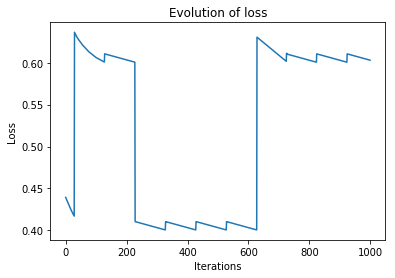

In [32]:
# Optimization parameters
theta_init = np.random.random(X[0].shape)
max_iter = 1000
step     = 1e-2
pen      = 1e-2

# Find theta 
np.set_printoptions(precision=2, threshold=5)
theta = gradient_l1(theta_init, X, y, max_iter=max_iter, step=step, pen=pen, verbose=0, plot=True)
print("theta found with gradient descent:", theta)
# theta_minimize = minimize(lambda t:loss(t, X, y, pen), theta_init).x
# print("theta with minimize():            ", theta_minimize)
print("Decision function:", decision(theta, X))
print("Real labels:", y)

In [8]:
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """ Custom linear classifier """
    
    def __init__(self, max_iter=1000, step=1e-2, pen=1e-2, verbose=0):
        self.theta= 0
        self.max_iter = max_iter
        self.step = step
        self.pen = pen
        self.verbose = verbose
    
    def fit(self, X, y):
        self.theta = gradient_l1(np.ones_like(X[0]), X, y, 
                                 max_iter=self.max_iter, 
                                 step=self.step, 
                                 pen=self.pen,
                                 verbose=self.verbose)
        
    def predict(self, X):
        return decision(theta, X)

    def get_theta(self):
        return self.theta

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import KFold



kf = KFold(n_splits=4)


for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    clf = LinearClassifier(max_iter=max_iter, step=step, pen=pen, verbose=0)
    clf.fit(X_train, Y_train)
    print("Theta found:", clf.get_theta())
    pred = clf.predict(X_test)
    
    print("KFold:")
    print("Y_Pred: ", pred)
    print("Y_reel: ", Y_test)
    print("Score: ", accuracy_score(pred, Y_test))
    print("Errors: ", Y_test[pred != Y_test])


Theta found: [-0.2508 -0.2508 -0.2508 -0.2508 -0.005  -0.005  -0.005  -0.005  -0.005
 -0.005 ]
KFold:
theta :  [-0.2508 -0.2508 -0.2508 -0.2508 -0.005  -0.005  -0.005  -0.005  -0.005
 -0.005 ]
Y_Pred:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.]
Y_reel:  [1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1]
Score:  0.72
Errors:  [0 0 0 0 0 0 0]
Theta found: [-0.005      -0.005      -0.005      -0.25117647 -0.005      -0.005      -0.005
 -0.005      -0.005      -0.005     ]
KFold:
theta :  [-0.005      -0.005      -0.005      -0.25117647 -0.005      -0.005      -0.005
 -0.005      -0.005      -0.005     ]
Y_Pred:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.]
Y_reel:  [0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1]
Score:  0.72
Errors:  [0 0 0 0 0 0 0]
Theta found: [-0.005      -0.005      -0.005      -0.49293746 -0.005      -0.005      -0.005
 -0.005      -0.005      -0